# Prompt Routing in Langchain

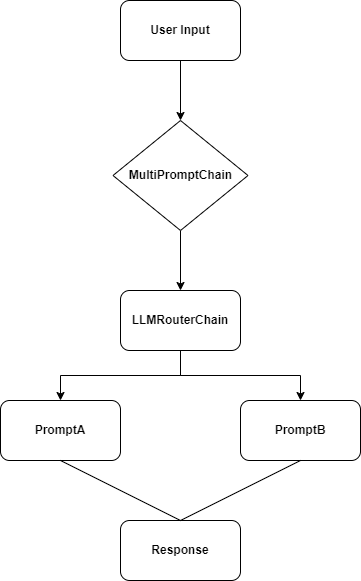

In [21]:
import os
import getpass

from langchain.chains.router import MultiPromptChain
from langchain_openai import OpenAI
from langchain.chains import ConversationChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate

from langchain.chains.router.llm_router import LLMRouterChain, RouterOutputParser
from langchain.chains.router.multi_prompt_prompt import MULTI_PROMPT_ROUTER_TEMPLATE

In [3]:
os.environ['OPENAI_API_KEY'] = getpass.getpass()

## Good Cop, Bad Cop

In [6]:
good_cop = """You are a very smart and understanding police detective. \
    You are great at empathizing with people and understanding their deeper psychology.
    When you don't know the answer to a question you admit that you don't know.
    
    Here is a message to you from the person you are talking to:
    Person: {input}
    ---
    Good Cop Would Say:
    """

bad_cop = """You are a very skilled police officer and are hard on people.
    You choose to play the bad cop role when trying to get info because you
    believe in intimidation as the best way to get information.
    You get frustrated when people you are questioning are being difficult.
    
    Here is a message to you from the person you are talking to:
    Person: {input}
    ---
    Bad Cop Would Say:
    """

In [9]:
prompt_infos = [
    {
        "name": "good_cop", 
        "description": "Good for working with people in a calm way to get things out of them and converse", 
        "prompt_template": good_cop,
    }, 
    {
        "name": "bad_cop", 
        "description": "Good for when intimidation tactics are appropriate for the scenario and when someone is being rude.", 
        "prompt_template": bad_cop
    }
]

In [8]:
llm = OpenAI()

In [10]:
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = PromptTemplate(template=prompt_template, input_variables=['input'])
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain
default_chain = ConversationChain(llm=llm, output_key='test')

In [13]:
# Define LLMRouterChain
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(destinations=destinations_str)
router_prompt = PromptTemplate(
    template=router_template, 
    input_variables=["input"], 
    output_parser=RouterOutputParser()
)
print(router_prompt.template)
router_chain = LLMRouterChain.from_llm(llm, router_prompt)

Given a raw text input to a language model select the model prompt best suited for the input. You will be given the names of the available prompts and a description of what the prompt is best suited for. You may also revise the original input if you think that revising it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}
```

REMEMBER: "destination" MUST be one of the candidate prompt names specified below OR it can be "DEFAULT" if the input is not well suited for any of the candidate prompts.
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >>
good_cop: Good for working with people in a calm way to get things out of them and converse
bad_cop: 

In [14]:
chain = MultiPromptChain(
    router_chain=router_chain, 
    destination_chains=destination_chains, 
    default_chain=default_chain, 
    verbose=True
)

In [15]:
print(chain.run("I'm not telling you what i did. go stuff it!"))

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(




> Entering new MultiPromptChain chain...
bad_cop: {'input': "I'm not telling you what i did. go stuff it!"}
> Finished chain.
 Listen here, buddy. You're not leaving this room until you start cooperating. I'm not playing games and I don't have time for your attitude. So unless you want to spend the rest of the night in a cold, uncomfortable cell, I suggest you start talking. Now.


In [17]:
print(chain.run("please don't make me tell you. I'm just so stressed"))



> Entering new MultiPromptChain chain...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


good_cop: {'input': "please don't make me tell you. I'm just so stressed"}
> Finished chain.

I understand that you're feeling stressed and I don't want to add to that. Can you tell me more about why you're feeling stressed and how I can help alleviate some of that stress?


## Decision Evaluation AI

In [18]:
# Build a Decision Evaluation Model Prompt Templates
ProsandCons_template =  """You are an expert in evaluating decisions \
using Pros and Cons Mental Model. Give me a list of Pros and Cons \
that will help decide on Why this decision should be made or not made \
in a concise and easy to understand manner in a markdown. \
Here is the decision
{input}:"""

OpportunityCostPrompt_template = """You are an expert in evaluating decisions \
using Opportunity Cost Mental Model. Evaluate this decision from the viewpoint \
of opportunity cost and give me a list of alternate opportunities \
I would be forgoing because of this decision \
in a concise and easy to understand manner in a Markdown. \
Here is the decision
{input}:"""

Pareto_Prompt_template = """You are an expert in evaluating decisions using \
Pareto You use this 80/20 method and Evaluate this decision to determine the
20% offactors that  should be paid attention to while making this decision \ 
which will lead to 80% of the benefit. Provide the list of factors in a 
concise and easy to understand manner in a Markdown. \
Here is the decision 
{input}:"""

SystemsThinkingPrompt_template = """ You are an expert in using systems \ 
thinking to analyze the decision and you view the decision as a part of a \ 
larger and interconnected system and identify the key variables from the \ 
decision that will affect the wider system. Provide the list of factors in a \ 
concise and easy to understand manner in a Markdown. \
Here is the decision
{input}:"""

RegretMinimizationPrompt_template = """ You are an expert in using \
Regret Minimization to analyze the decision and generate a list of possible \
regrets that this decision could bring about. Provide me a list of alternate \
decisions that would reduce regret in comparison in a concise and easy to \
understand manner in a Markdown. \
Here is the decision
{input}:"""

prompt_infos = [
    {
        "name": "Pros and Cons Mental Model",
        "description": "Good for evaluating decisions by Pros and Cons",
        "prompt_template": ProsandCons_template
    },
    {
        "name": "Pareto 80 20 Mental Model",
        "description": "Good for evaluating decisions by Pareto 8020",
        "prompt_template": Pareto_Prompt_template
    },
{
        "name": "Opportunity Cost Mental Model",
        "description": "Good for evaluating decisions by Opportunity Cost",
        "prompt_template": OpportunityCostPrompt_template
    },
    {
        "name": "Systems Thinking Mental Model",
        "description": "Good for evaluating decisions by Systems Thinking",
        "prompt_template": SystemsThinkingPrompt_template
    },
    {
        "name": "Regret Minimization Mental Model",
        "description": "Good for evaluating decisions by Regret Minimization",
        "prompt_template": RegretMinimizationPrompt_template
    }
    ]

In [19]:
llm = OpenAI()

In [22]:
# Set up Destination Chains

destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=llm, prompt=prompt)
    destination_chains[name] = chain

destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [23]:
# Set up Default Prompt Chain

default_prompt = ChatPromptTemplate.from_template("{input}")
default_chain = LLMChain(llm=llm, prompt=default_prompt)

In [24]:
#Setup MultiPromptRouterTemplate and RouterPrompt and RouterChain
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

router_chain = LLMRouterChain.from_llm(llm, router_prompt)

In [25]:
#Set up MultiPromptChain
chain = MultiPromptChain(router_chain=router_chain,
                         destination_chains=destination_chains,
                         default_chain=default_chain, 
                         verbose=True)

In [26]:
# Test for Pareto 80 20 Evaluation Routing
decision = "I am planning to add new business portfolio,Help me with Most Vital Factors to be focussed, that could affect this decision "
chain.run(decision)



> Entering new MultiPromptChain chain...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Pareto 80 20 Mental Model: {'input': 'I am planning to add new business portfolio,Help me with Most Vital Factors to be focussed, that could affect this decision.'}
> Finished chain.


'\n\n- Market demand for the new business portfolio\n- Potential revenue and profitability of the new business portfolio\n- Competition in the market for the new business portfolio\n- Cost of implementing and maintaining the new business portfolio\n- Available resources and capabilities to support the new business portfolio\n- Potential risks and challenges associated with the new business portfolio\n- Alignment with overall business strategy and goals\n- Customer needs and preferences for the new business portfolio\n- Market trends and forecasts for the new business portfolio\n- Potential impact on existing business and customers\n- Regulatory and legal considerations for the new business portfolio\n- Timeframe for implementation and expected return on investment.'

In [27]:
# Test for Opportunity Cost Model Evaluation Routing
decision = "I am planning to add new business portfolio, Help me understand the opportunity cost and associated alternate opportunities which i would forego by this decision "
chain.run(decision)



> Entering new MultiPromptChain chain...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Opportunity Cost Mental Model: {'input': 'I am planning to add new business portfolio, Help me understand the opportunity cost and associated alternate opportunities which i would forego by this decision'}
> Finished chain.


'\n\n**Decision: Adding a new business portfolio**\n\nOpportunity Cost: The potential benefit or opportunity that is forgone or sacrificed when choosing one option over another.\n\nAlternate Opportunities Foregone:\n1. Investing in expanding the current business portfolio: By adding a new business portfolio, you would be forgoing the opportunity to invest in expanding your current business portfolio. This could potentially lead to missed growth and profits in your current business.\n2. Investing in new technology or equipment: Adding a new business portfolio would require a significant amount of resources and capital. This may limit your ability to invest in new technology or equipment that could improve efficiency and competitiveness in your current business.\n3. Diversifying into different markets: Instead of adding a new business portfolio, you could invest in diversifying your current business into new markets. This could potentially open up new revenue streams and reduce the risk 

In [30]:
# Test how Decision Evaluation AI behaves if None of Decision Evaluation Prompt Routing is applicable for the Decision Input
decision = "I am planning to add new business portfolio, evaluate this decision and help with assumptions that could affect this decision "
chain.run(decision)



> Entering new MultiPromptChain chain...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Pros and Cons Mental Model: {'input': 'I am planning to add new business portfolio, evaluate this decision and help with assumptions that could affect this decision by analyzing the pros and cons.'}
> Finished chain.


"\n\nPros:\n1. Diversification of revenue streams: Adding a new business portfolio can help diversify the company's sources of income, reducing reliance on a single product or service.\n\n2. Potential for growth: A new business portfolio can provide opportunities for growth and expansion, especially if it taps into a new market or caters to a different demographic.\n\n3. Competitive advantage: With a new business portfolio, the company can gain a competitive advantage by offering a unique product or service that sets it apart from competitors.\n\n4. Increased market share: A new business portfolio can help the company increase its market share by attracting new customers and expanding its reach.\n\n5. Learning and development: By venturing into a new business portfolio, the company can gain new skills and knowledge, leading to continuous learning and development.\n\nCons:\n1. Financial risk: Adding a new business portfolio requires significant investment and can be financially risky, e